In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# So we dont have to use plt.show() every time:
%matplotlib inline

In [2]:
IMAGE_SIZE = 256
IMAGE_CHANNELS = 3
EPOCS = 10
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory="dataset",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    labels='inferred',
    shuffle=True,
)

Found 4500 files belonging to 3 classes.


In [4]:
CLASS_NAMES = dataset.class_names
print("Class names:", CLASS_NAMES)
print(len(dataset)*BATCH_SIZE)

Class names: ['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']
4512


Image batch shape: (32, 256, 256, 3)
Label batch as a tensor: tf.Tensor([2 1 1 1 1 2 1 2 2 2 2 1 1 2 0 0 2 1 2 2 2 2 0 0 0 2 1 1 0 1 0 1], shape=(32,), dtype=int32)
Label batch as numpy array: [2 1 1 1 1 2 1 2 2 2 2 1 1 2 0 0 2 1 2 2 2 2 0 0 0 2 1 1 0 1 0 1]
First image in batch raw tensor: tf.Tensor(
[[[170. 167. 178.]
  [149. 146. 157.]
  [180. 177. 188.]
  ...
  [104.  96. 109.]
  [126. 118. 131.]
  [ 87.  79.  92.]]

 [[175. 172. 183.]
  [143. 140. 151.]
  [190. 187. 198.]
  ...
  [103.  95. 108.]
  [158. 150. 163.]
  [128. 120. 133.]]

 [[155. 152. 163.]
  [201. 198. 209.]
  [205. 202. 213.]
  ...
  [114. 106. 119.]
  [ 82.  74.  87.]
  [156. 148. 161.]]

 ...

 [[174. 167. 175.]
  [181. 174. 182.]
  [182. 175. 183.]
  ...
  [140. 130. 138.]
  [ 92.  82.  90.]
  [136. 126. 134.]]

 [[150. 143. 151.]
  [171. 164. 172.]
  [173. 166. 174.]
  ...
  [164. 154. 162.]
  [113. 103. 111.]
  [110. 100. 108.]]

 [[135. 128. 136.]
  [147. 140. 148.]
  [140. 133. 141.]
  ...
  [152. 142. 150.]

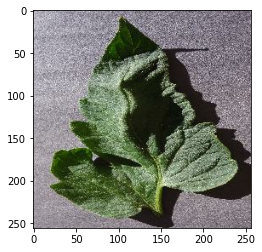

In [5]:
for image_batch, label_batch in dataset.take(1): # First batch
    print("Image batch shape:", image_batch.shape)
    print("Label batch as a tensor:", label_batch)
    print("Label batch as numpy array:", label_batch.numpy())
    print("First image in batch raw tensor:", image_batch[0])
    print("First image visualization:")
    plt.imshow(image_batch[0].numpy().astype(np.uint8))
    break

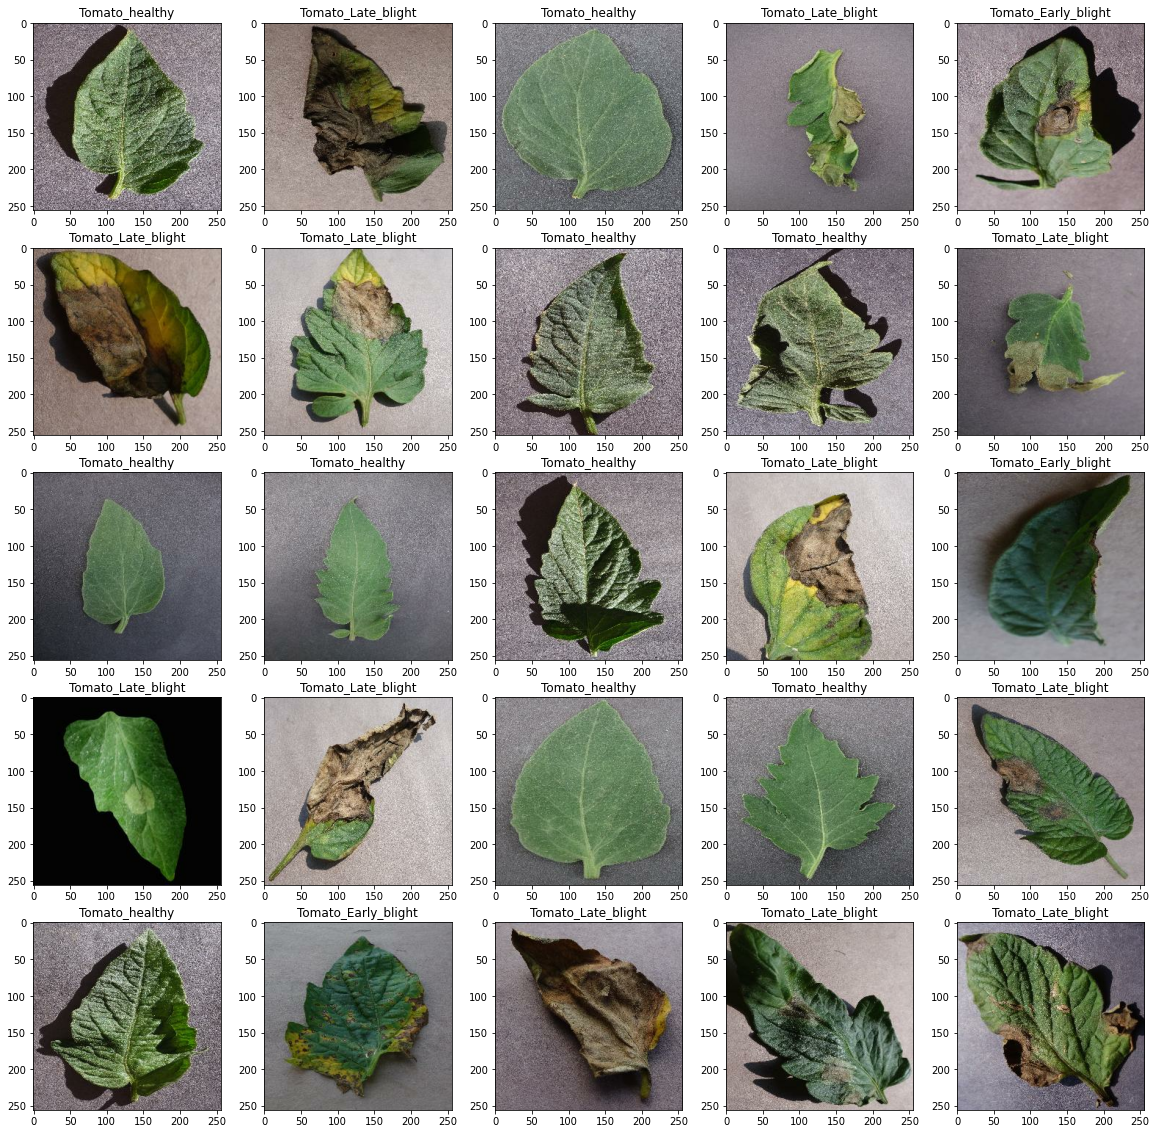

In [6]:

# plotting first 25 images in the batch
plt.figure(figsize=(20, 20))
for image_batch, label_batch in dataset.take(1):
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(image_batch[i].numpy().astype(np.uint8))
        plt.title(CLASS_NAMES[label_batch[i].numpy()])

In [7]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    """
    Returns a tuple of (train_dataset, val_dataset, test_dataset)
    """
    ds_size = len(dataset)

    # Shuffle the dataset
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=42)
    
    train_take = int(train_split * ds_size)
    val_take = int(val_split * ds_size)
    test_take = int(test_split * ds_size)

    train_dataset = dataset.take(train_take)
    val_dataset = dataset.skip(train_take).take(val_take)
    test_dataset = dataset.skip(train_take + val_take)

    return train_dataset, val_dataset, test_dataset


In [8]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [9]:
# Cache, shuffle and prefetch the datasets
train_dataset = train_dataset.cache().shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)


In [11]:
# resize and rescale layer:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

# Data augmentation layer:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomFlip('horizontal_and_vertical'),
])

In [14]:
# Model building:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))

In [15]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_dataset,
    epochs=EPOCS,
    validation_data=val_dataset,
    verbose=1
)

Epoch 1/10
 12/112 [==>...........................] - ETA: 2:42 - loss: 1.7257 - accuracy: 0.3906

KeyboardInterrupt: 